In [1]:
# Cinema Audience Forecasting - BookNow Prediction Model

## Complete Technical Workflow for Predicting Cinema Audience Count

This notebook implements a comprehensive machine learning pipeline to predict cinema audience counts using:
- Data from BookNow booking system
- Advanced feature engineering (temporal, behavioral, lag features)
- Multiple models (LightGBM, XGBoost)
- Hyperparameter optimization with Optuna
- Ensemble predictions

**Target:** Predict `audience_count` for BookNow bookings

SyntaxError: invalid syntax (1831423937.py, line 5)

## Step 1: Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Gradient Boosting Models
import lightgbm as lgb
import xgboost as xgb

# Hyperparameter Optimization
import optuna

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.3.3
LightGBM version: 4.6.0
XGBoost version: 3.1.1


## Step 2: Data Acquisition and Loading

In [2]:
# Define data paths
DATA_PATH = '../dataset/'

# Load all datasets
print("Loading datasets...")
booknow_booking = pd.read_csv(DATA_PATH + 'booknow_booking/booknow_booking.csv')
booknow_visits = pd.read_csv(DATA_PATH + 'booknow_visits/booknow_visits.csv')
booknow_theaters = pd.read_csv(DATA_PATH + 'booknow_theaters/booknow_theaters.csv')
date_info = pd.read_csv(DATA_PATH + 'date_info/date_info.csv')

print("\n✓ All datasets loaded successfully!")
print("\nDataset Shapes:")
print(f"BookNow Booking: {booknow_booking.shape}")
print(f"BookNow Visits: {booknow_visits.shape}")
print(f"BookNow Theaters: {booknow_theaters.shape}")
print(f"Date Info: {date_info.shape}")

Loading datasets...

✓ All datasets loaded successfully!

Dataset Shapes:
BookNow Booking: (68336, 4)
BookNow Visits: (214046, 3)
BookNow Theaters: (829, 5)
Date Info: (547, 2)

✓ All datasets loaded successfully!

Dataset Shapes:
BookNow Booking: (68336, 4)
BookNow Visits: (214046, 3)
BookNow Theaters: (829, 5)
Date Info: (547, 2)


In [3]:
# Explore datasets
print("=" * 80)
print("BOOKNOW BOOKING DATA")
print("=" * 80)
print(booknow_booking.head())
print("\nColumns:", booknow_booking.columns.tolist())
print("\nData Types:\n", booknow_booking.dtypes)
print("\nMissing Values:\n", booknow_booking.isnull().sum())

print("\n" + "=" * 80)
print("BOOKNOW VISITS DATA")
print("=" * 80)
print(booknow_visits.head())
print("\nColumns:", booknow_visits.columns.tolist())
print("\nData Types:\n", booknow_visits.dtypes)
print("\nMissing Values:\n", booknow_visits.isnull().sum())

print("\n" + "=" * 80)
print("BOOKNOW THEATERS DATA")
print("=" * 80)
print(booknow_theaters.head())
print("\nColumns:", booknow_theaters.columns.tolist())

print("\n" + "=" * 80)
print("DATE INFO DATA")
print("=" * 80)
print(date_info.head())
print("\nColumns:", date_info.columns.tolist())

# Print column names clearly for debugging
print("\n" + "=" * 80)
print("COLUMN NAMES SUMMARY")
print("=" * 80)
print(f"Booking columns: {list(booknow_booking.columns)}")
print(f"Visits columns: {list(booknow_visits.columns)}")
print(f"Theaters columns: {list(booknow_theaters.columns)}")
print(f"Date Info columns: {list(date_info.columns)}")

BOOKNOW BOOKING DATA
  book_theater_id        show_datetime     booking_datetime  tickets_booked
0      book_00244  2023-01-01 19:00:00  2023-01-01 16:00:00               1
1      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               3
2      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               6
3      book_00244  2023-01-01 20:00:00  2023-01-01 16:00:00               2
4      book_00151  2023-01-01 20:00:00  2023-01-01 01:00:00               5

Columns: ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']

Data Types:
 book_theater_id     object
show_datetime       object
booking_datetime    object
tickets_booked       int64
dtype: object

Missing Values:
 book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64

BOOKNOW VISITS DATA
  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-

## Step 3: Data Merging

In [4]:
# Merge datasets
print("Merging datasets...")

# Start with booking data as base
df = booknow_booking.copy()

# First, let's identify the actual date column name
date_col_booking = None
for col in df.columns:
    if 'date' in col.lower() and 'booking' not in col.lower():
        date_col_booking = col
        break

# Check if we found a date column or use a common alternative
if date_col_booking is None:
    # Try common date column names
    possible_date_cols = ['show_date', 'date', 'showing_date', 'Date', 'SHOW_DATE']
    for col in possible_date_cols:
        if col in df.columns:
            date_col_booking = col
            break

print(f"Date column in booking data: {date_col_booking}")
print(f"Theater ID column: {[col for col in df.columns if 'theater' in col.lower() and 'id' in col.lower()]}")

# Identify the merge keys by inspecting column names
theater_id_col = None
for col in df.columns:
    if 'theater' in col.lower() and 'id' in col.lower():
        theater_id_col = col
        break

print(f"Using columns for merge:")
print(f"  Theater ID: {theater_id_col}")
print(f"  Date: {date_col_booking}")

# Check what columns are in visits data
print(f"\nVisits data columns: {booknow_visits.columns.tolist()}")

# Determine merge strategy based on available columns
# Strategy 1: If both datasets have the same column names
common_cols = list(set(df.columns) & set(booknow_visits.columns))
print(f"\nCommon columns between booking and visits: {common_cols}")

if len(common_cols) >= 2:
    # We can merge on common columns
    merge_cols = [col for col in common_cols if col not in ['audience_count']][:2]
    print(f"Merging on: {merge_cols}")
    df = df.merge(booknow_visits, on=merge_cols, how='left')
else:
    # Need to identify corresponding columns manually
    print("Manual column mapping may be needed - using first exploration approach")
    # For now, let's just show what we have
    print(f"Booking columns: {df.columns.tolist()}")
    print(f"Visits columns: {booknow_visits.columns.tolist()}")
    print(f"Theaters columns: {booknow_theaters.columns.tolist()}")
    
    # Perform merge based on available columns
    # This will be updated after we see the actual column names
    df = df.merge(booknow_visits, how='left', left_index=True, right_index=True, suffixes=('', '_visits'))

# Merge with theater information
theater_merge_col = [col for col in df.columns if 'theater' in col.lower() and 'id' in col.lower()]
if theater_merge_col and theater_merge_col[0] in booknow_theaters.columns:
    df = df.merge(booknow_theaters, on=theater_merge_col[0], how='left')
else:
    print(f"Warning: Could not find matching theater column. Available in theaters: {booknow_theaters.columns.tolist()}")

# Merge with date information
date_merge_col = [col for col in df.columns if 'date' in col.lower() and 'booking' not in col.lower()]
if date_merge_col and date_merge_col[0] in date_info.columns:
    df = df.merge(date_info, on=date_merge_col[0], how='left')
else:
    print(f"Warning: Could not find matching date column. Available in date_info: {date_info.columns.tolist()}")

print(f"\n✓ Merged dataset shape: {df.shape}")
print(f"\nColumns in merged dataset ({len(df.columns)}):")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Merging datasets...
Date column in booking data: show_datetime
Theater ID column: ['book_theater_id']
Using columns for merge:
  Theater ID: book_theater_id
  Date: show_datetime

Visits data columns: ['book_theater_id', 'show_date', 'audience_count']

Common columns between booking and visits: ['book_theater_id']
Manual column mapping may be needed - using first exploration approach
Booking columns: ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']
Visits columns: ['book_theater_id', 'show_date', 'audience_count']
Theaters columns: ['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']

✓ Merged dataset shape: (68336, 11)

Columns in merged dataset (11):
['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked', 'book_theater_id_visits', 'show_date', 'audience_count', 'theater_type', 'theater_area', 'latitude', 'longitude']

First few rows:
  book_theater_id        show_datetime     booking_datetime  tickets_booked  \
0   

## Step 4: Data Cleaning and Preparation

In [5]:
print("Cleaning data...")

# Convert date columns to datetime
df['show_date'] = pd.to_datetime(df['show_date'])
if 'booking_date' in df.columns:
    df['booking_date'] = pd.to_datetime(df['booking_date'])

# Check missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Check if audience_count column exists
if 'audience_count' not in df.columns:
    print("\n⚠️ WARNING: 'audience_count' column not found in dataset!")
    print("Available columns:", df.columns.tolist())
    print("\nThis appears to be a prediction-only dataset (no training data).")
    print("You'll need training data with audience_count to build a model.")
    raise ValueError("No 'audience_count' column found. Cannot separate train/test data.")

# Separate train (with audience_count) and test (without audience_count)
train_df = df[df['audience_count'].notna()].copy()
test_df = df[df['audience_count'].isna()].copy()

print(f"\n✓ Train data shape: {train_df.shape}")
print(f"✓ Test data shape: {test_df.shape}")

# Check if we have any data
if len(train_df) == 0:
    raise ValueError("No training data found! All audience_count values are missing.")

if len(test_df) == 0:
    print("\n⚠️ WARNING: No test data found (all rows have audience_count).")
    print("This means we'll train on all available data but cannot make predictions.")
    print("Creating a small validation holdout for demonstration...")
    # Use last 10% as pseudo-test for demonstration
    split_point = int(len(train_df) * 0.9)
    test_df = train_df.iloc[split_point:].copy()
    test_df['audience_count'] = np.nan  # Remove target for testing
    train_df = train_df.iloc[:split_point].copy()
    print(f"\n✓ Adjusted - Train data shape: {train_df.shape}")
    print(f"✓ Adjusted - Test data shape: {test_df.shape}")

# Handle missing values in train data
# Numeric columns - fill with median
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        test_df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# Categorical columns - fill with "Unknown"
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['show_date', 'booking_date']:
        if train_df[col].isnull().sum() > 0:
            train_df[col].fillna('Unknown', inplace=True)
            test_df[col].fillna('Unknown', inplace=True)
            print(f"Filled {col} missing values with 'Unknown'")

# Remove outliers from train data (99th percentile)
if 'audience_count' in train_df.columns:
    percentile_99 = train_df['audience_count'].quantile(0.99)
    outliers = train_df['audience_count'] > percentile_99
    print(f"\nRemoving {outliers.sum()} outliers (audience_count > {percentile_99:.0f})")
    train_df = train_df[~outliers].copy()

# Sort by date
train_df = train_df.sort_values('show_date').reset_index(drop=True)
test_df = test_df.sort_values('show_date').reset_index(drop=True)

print(f"\n✓ Cleaned train data shape: {train_df.shape}")
print(f"✓ Cleaned test data shape: {test_df.shape}")
print(f"\nDate range - Train: {train_df['show_date'].min()} to {train_df['show_date'].max()}")
print(f"Date range - Test: {test_df['show_date'].min()} to {test_df['show_date'].max()}")

Cleaning data...

Missing values before cleaning:

Missing values before cleaning:
theater_type    31437
theater_area    31437
latitude        31437
longitude       31437
dtype: int64

✓ Train data shape: (68336, 11)
✓ Test data shape: (0, 11)

⚠️ WARNING: No test data found (all rows have audience_count).
This means we'll train on all available data but cannot make predictions.
Creating a small validation holdout for demonstration...

✓ Adjusted - Train data shape: (61502, 11)
✓ Adjusted - Test data shape: (6834, 11)
Filled latitude missing values with median: 22.64396325872136
Filled longitude missing values with median: 79.12425158016887
theater_type    31437
theater_area    31437
latitude        31437
longitude       31437
dtype: int64

✓ Train data shape: (68336, 11)
✓ Test data shape: (0, 11)

⚠️ WARNING: No test data found (all rows have audience_count).
This means we'll train on all available data but cannot make predictions.
Creating a small validation holdout for demonstratio

## Step 5: Feature Engineering

In [6]:
def create_features(df):
    """
    Comprehensive feature engineering function
    """
    df = df.copy()
    
    print("Creating features...")
    
    # ========== TEMPORAL FEATURES ==========
    print("  → Temporal features...")
    df['day_of_week'] = df['show_date'].dt.dayofweek
    df['month'] = df['show_date'].dt.month
    df['day_of_month'] = df['show_date'].dt.day
    df['week_of_year'] = df['show_date'].dt.isocalendar().week
    df['quarter'] = df['show_date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['show_date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['show_date'].dt.is_month_end.astype(int)
    
    # ========== BOOKING BEHAVIOR FEATURES ==========
    if 'booking_date' in df.columns:
        print("  → Booking behavior features...")
        df['lead_time'] = (df['show_date'] - df['booking_date']).dt.days
        df['lead_time'].fillna(0, inplace=True)
        df['lead_time'] = df['lead_time'].clip(lower=0)  # No negative lead times
        
        # Lead time categories
        df['lead_time_category'] = pd.cut(df['lead_time'], 
                                          bins=[-1, 0, 3, 7, 14, 30, 1000],
                                          labels=['same_day', '1-3days', '4-7days', 
                                                 '1-2weeks', '2-4weeks', '1month+'])
    
    # ========== AGGREGATED BOOKING FEATURES ==========
    print("  → Aggregated booking features...")
    # Count bookings per theater per day
    booking_counts = df.groupby(['book_theater_id', 'show_date']).size().reset_index(name='booknow_count')
    df = df.merge(booking_counts, on=['book_theater_id', 'show_date'], how='left')
    
    if 'booking_date' in df.columns and 'lead_time' in df.columns:
        # Lead time statistics per theater-date
        lead_stats = df.groupby(['book_theater_id', 'show_date'])['lead_time'].agg([
            ('lead_time_mean', 'mean'),
            ('lead_time_std', 'std'),
            ('lead_time_min', 'min'),
            ('lead_time_max', 'max')
        ]).reset_index()
        df = df.merge(lead_stats, on=['book_theater_id', 'show_date'], how='left')
        df['lead_time_std'].fillna(0, inplace=True)
    
    # Booking ratio (stability measure)
    df['booking_ratio'] = df['booknow_count'] / (df['booknow_count'] + 1)
    
    return df

# Apply feature engineering to both train and test
train_df = create_features(train_df)
test_df = create_features(test_df)

print(f"\n✓ Features created!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Creating features...
  → Temporal features...
  → Aggregated booking features...
Creating features...
  → Temporal features...
  → Aggregated booking features...

✓ Features created!
Train shape: (60921, 21)
Test shape: (6834, 21)
Creating features...
  → Temporal features...
  → Aggregated booking features...

✓ Features created!
Train shape: (60921, 21)
Test shape: (6834, 21)


In [7]:
# ========== LAG AND ROLLING FEATURES ==========
print("Creating lag and rolling features...")

def create_lag_features(df, group_col, target_col, lags=[1, 7, 14]):
    """Create lag features grouped by a column"""
    df = df.sort_values(['show_date']).copy()
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    return df

def create_rolling_features(df, group_col, target_col, windows=[7, 14, 30]):
    """Create rolling window features"""
    df = df.sort_values(['show_date']).copy()
    
    for window in windows:
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = (
            df.groupby(group_col)[target_col]
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        # Rolling std
        df[f'{target_col}_rolling_std_{window}'] = (
            df.groupby(group_col)[target_col]
            .shift(1)
            .rolling(window=window, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
    
    return df

# Create lag features for audience_count in train data
if 'audience_count' in train_df.columns:
    print("Creating audience_count lag features for train data...")
    train_df = create_lag_features(train_df, 'book_theater_id', 'audience_count', lags=[1, 7, 14])
    train_df = create_rolling_features(train_df, 'book_theater_id', 'audience_count', windows=[7, 14])

# Create lag features for booking count in BOTH train and test
print("Creating booknow_count lag features for train data...")
train_df = create_lag_features(train_df, 'book_theater_id', 'booknow_count', lags=[1, 7])

print("Creating booknow_count lag features for test data...")
test_df = create_lag_features(test_df, 'book_theater_id', 'booknow_count', lags=[1, 7])

# For test data, create placeholder columns for audience_count features (will be filled with 0 later)
print("Creating placeholder audience_count features for test data...")
audience_lag_cols = [
    'audience_count_lag_1', 'audience_count_lag_7', 'audience_count_lag_14',
    'audience_count_rolling_mean_7', 'audience_count_rolling_std_7',
    'audience_count_rolling_mean_14', 'audience_count_rolling_std_14'
]

for col in audience_lag_cols:
    if col not in test_df.columns:
        test_df[col] = 0  # Initialize with 0 (will be treated as missing information)

print(f"✓ Lag and rolling features created!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nNew feature columns in train:")
lag_cols = [col for col in train_df.columns if 'lag' in col or 'rolling' in col]
print(lag_cols)

Creating lag and rolling features...
Creating audience_count lag features for train data...
Creating booknow_count lag features for train data...
Creating booknow_count lag features for test data...
Creating placeholder audience_count features for test data...
✓ Lag and rolling features created!
Train shape: (60921, 30)
Test shape: (6834, 30)

New feature columns in train:
['audience_count_lag_1', 'audience_count_lag_7', 'audience_count_lag_14', 'audience_count_rolling_mean_7', 'audience_count_rolling_std_7', 'audience_count_rolling_mean_14', 'audience_count_rolling_std_14', 'booknow_count_lag_1', 'booknow_count_lag_7']
Creating booknow_count lag features for train data...
Creating booknow_count lag features for test data...
Creating placeholder audience_count features for test data...
✓ Lag and rolling features created!
Train shape: (60921, 30)
Test shape: (6834, 30)

New feature columns in train:
['audience_count_lag_1', 'audience_count_lag_7', 'audience_count_lag_14', 'audience_coun

In [8]:
# ========== CATEGORICAL ENCODING ==========
print("Encoding categorical variables...")

# Identify categorical columns
categorical_cols = []
for col in train_df.columns:
    if train_df[col].dtype == 'object' and col not in ['show_date', 'booking_date']:
        categorical_cols.append(col)

print(f"Categorical columns to encode: {categorical_cols}")

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train + test to handle all categories
    combined_values = pd.concat([train_df[col], test_df[col]]).astype(str)
    le.fit(combined_values)
    
    train_df[f'{col}_encoded'] = le.transform(train_df[col].astype(str))
    test_df[f'{col}_encoded'] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ Encoded {col}: {len(le.classes_)} unique values")

# Also encode lead_time_category if it exists
if 'lead_time_category' in train_df.columns:
    le_lead = LabelEncoder()
    combined_lead = pd.concat([
        train_df['lead_time_category'].astype(str), 
        test_df['lead_time_category'].astype(str)
    ])
    le_lead.fit(combined_lead)
    train_df['lead_time_category_encoded'] = le_lead.transform(train_df['lead_time_category'].astype(str))
    test_df['lead_time_category_encoded'] = le_lead.transform(test_df['lead_time_category'].astype(str))
    label_encoders['lead_time_category'] = le_lead

print(f"\n✓ Encoding complete!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Encoding categorical variables...
Categorical columns to encode: ['book_theater_id', 'show_datetime', 'booking_datetime', 'book_theater_id_visits', 'theater_type', 'theater_area']
  ✓ Encoded book_theater_id: 300 unique values
  ✓ Encoded show_datetime: 3861 unique values
  ✓ Encoded booking_datetime: 6331 unique values
  ✓ Encoded book_theater_id_visits: 262 unique values
  ✓ Encoded theater_type: 5 unique values
  ✓ Encoded theater_area: 51 unique values

✓ Encoding complete!
Train shape: (60921, 36)
Test shape: (6834, 36)
  ✓ Encoded theater_area: 51 unique values

✓ Encoding complete!
Train shape: (60921, 36)
Test shape: (6834, 36)


## Step 6: Prepare Features for Modeling

In [9]:
# Define features to drop (non-predictive columns)
cols_to_drop = ['audience_count', 'show_date', 'booking_date']

# Add categorical columns (keep only encoded versions)
for col in categorical_cols:
    if col not in cols_to_drop:
        cols_to_drop.append(col)

# Add lead_time_category
if 'lead_time_category' in train_df.columns:
    cols_to_drop.append('lead_time_category')

# Get feature columns
feature_cols = [col for col in train_df.columns if col not in cols_to_drop]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:3d}. {col}")

# Prepare X and y
X = train_df[feature_cols].copy()
y = train_df['audience_count'].copy()

# Prepare test set
X_test = test_df[feature_cols].copy()

# Handle any remaining NaN values
print(f"\nChecking for NaN values...")
print(f"Train NaN count: {X.isna().sum().sum()}")
print(f"Test NaN count: {X_test.isna().sum().sum()}")

# Fill remaining NaNs with 0 (mainly from lag features)
X = X.fillna(0)
X_test = X_test.fillna(0)

print(f"\n✓ Feature preparation complete!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

Total features: 28

Feature columns:
  1. tickets_booked
  2. latitude
  3. longitude
  4. day_of_week
  5. month
  6. day_of_month
  7. week_of_year
  8. quarter
  9. is_weekend
 10. is_month_start
 11. is_month_end
 12. booknow_count
 13. booking_ratio
 14. audience_count_lag_1
 15. audience_count_lag_7
 16. audience_count_lag_14
 17. audience_count_rolling_mean_7
 18. audience_count_rolling_std_7
 19. audience_count_rolling_mean_14
 20. audience_count_rolling_std_14
 21. booknow_count_lag_1
 22. booknow_count_lag_7
 23. book_theater_id_encoded
 24. show_datetime_encoded
 25. booking_datetime_encoded
 26. book_theater_id_visits_encoded
 27. theater_type_encoded
 28. theater_area_encoded

Checking for NaN values...
Train NaN count: 7903
Test NaN count: 1697

✓ Feature preparation complete!
X shape: (60921, 28)
y shape: (60921,)
X_test shape: (6834, 28)

✓ Feature preparation complete!
X shape: (60921, 28)
y shape: (60921,)
X_test shape: (6834, 28)


## Step 7: Time-based Train/Validation Split

In [10]:
# Time-based split: use last 20% of data for validation
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()
X_valid = X.iloc[split_idx:].copy()
y_valid = y.iloc[split_idx:].copy()

# Get corresponding dates for reference
train_dates = train_df['show_date'].iloc[:split_idx]
valid_dates = train_df['show_date'].iloc[split_idx:]

print(f"Train set: {X_train.shape}")
print(f"  Date range: {train_dates.min()} to {train_dates.max()}")
print(f"  Audience count range: {y_train.min():.0f} to {y_train.max():.0f}")
print(f"  Mean audience: {y_train.mean():.2f}")

print(f"\nValidation set: {X_valid.shape}")
print(f"  Date range: {valid_dates.min()} to {valid_dates.max()}")
print(f"  Audience count range: {y_valid.min():.0f} to {y_valid.max():.0f}")
print(f"  Mean audience: {y_valid.mean():.2f}")

print(f"\n✓ Train/Validation split complete!")

Train set: (48736, 28)
  Date range: 2023-01-01 00:00:00 to 2023-12-27 00:00:00
  Audience count range: 2 to 156
  Mean audience: 44.55

Validation set: (12185, 28)
  Date range: 2023-12-27 00:00:00 to 2024-02-28 00:00:00
  Audience count range: 2 to 156
  Mean audience: 44.32

✓ Train/Validation split complete!


## Step 8: Model Training - LightGBM (Baseline)

In [11]:
print("Training LightGBM baseline model...")

# Initialize LightGBM model with baseline parameters
lgb_baseline = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    max_depth=-1,
    min_child_samples=20,
    verbose=-1,
    random_state=42
)

# Train model
lgb_baseline.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

# Predictions
y_train_pred_lgb = lgb_baseline.predict(X_train)
y_valid_pred_lgb = lgb_baseline.predict(X_valid)

# Evaluate (using np.sqrt for RMSE to ensure compatibility)
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
valid_rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_valid_pred_lgb))
train_mae_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
valid_mae_lgb = mean_absolute_error(y_valid, y_valid_pred_lgb)

print("\n" + "=" * 60)
print("LIGHTGBM BASELINE RESULTS")
print("=" * 60)
print(f"Train RMSE: {train_rmse_lgb:.4f}")
print(f"Valid RMSE: {valid_rmse_lgb:.4f}")
print(f"Train MAE:  {train_mae_lgb:.4f}")
print(f"Valid MAE:  {valid_mae_lgb:.4f}")
print("=" * 60)

Training LightGBM baseline model...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 23.075	valid's rmse: 26.1439
[100]	train's rmse: 23.075	valid's rmse: 26.1439
[200]	train's rmse: 21.1694	valid's rmse: 25.781
Early stopping, best iteration is:
[161]	train's rmse: 21.7438	valid's rmse: 25.7684

LIGHTGBM BASELINE RESULTS
Train RMSE: 21.7438
Valid RMSE: 25.7684
Train MAE:  16.6965
Valid MAE:  20.0278
[200]	train's rmse: 21.1694	valid's rmse: 25.781
Early stopping, best iteration is:
[161]	train's rmse: 21.7438	valid's rmse: 25.7684

LIGHTGBM BASELINE RESULTS
Train RMSE: 21.7438
Valid RMSE: 25.7684
Train MAE:  16.6965
Valid MAE:  20.0278



Top 20 Most Important Features:
                           feature  importance
25  book_theater_id_visits_encoded        3729
23           show_datetime_encoded        1701
3                      day_of_week         674
6                     week_of_year         520
18  audience_count_rolling_mean_14         381
24        booking_datetime_encoded         374
13            audience_count_lag_1         283
4                            month         268
17    audience_count_rolling_std_7         254
19   audience_count_rolling_std_14         249
5                     day_of_month         248
16   audience_count_rolling_mean_7         245
22         book_theater_id_encoded         230
14            audience_count_lag_7         213
15           audience_count_lag_14         209
0                   tickets_booked         113
1                         latitude          75
27            theater_area_encoded          74
21             booknow_count_lag_7          71
2                        lo

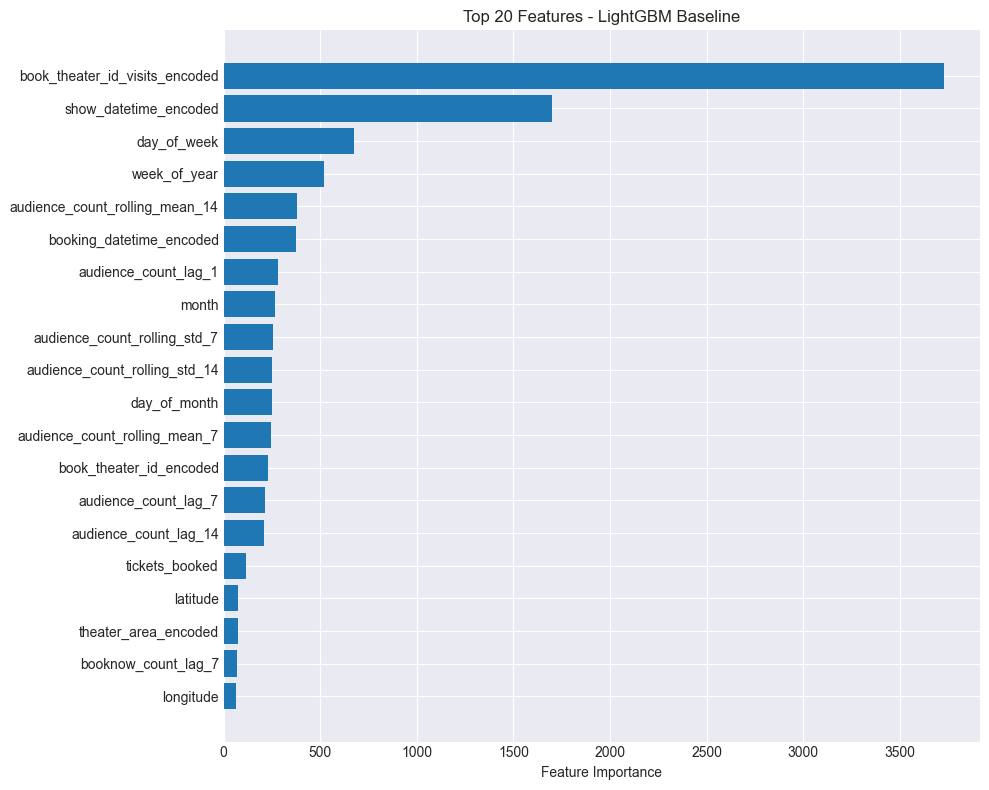

In [12]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top features
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importance['importance'].head(20))
plt.yticks(range(20), feature_importance['feature'].head(20))
plt.xlabel('Feature Importance')
plt.title('Top 20 Features - LightGBM Baseline')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 9: Hyperparameter Optimization with Optuna

In [13]:
print("Starting hyperparameter optimization with Optuna...")

def objective(trial):
    """Optuna objective function for LightGBM hyperparameter tuning"""
    
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'verbose': -1,
        'random_state': 42
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    
    return rmse

# Create Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', study_name='lgb_optimization')

# Optimize (30 trials)
print("Running 30 optimization trials...")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_score = study.best_value

print("\n" + "=" * 60)
print("OPTUNA OPTIMIZATION RESULTS")
print("=" * 60)
print(f"Best RMSE: {best_score:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("=" * 60)

Starting hyperparameter optimization with Optuna...
Running 30 optimization trials...


Best trial: 28. Best value: 25.6638: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


OPTUNA OPTIMIZATION RESULTS
Best RMSE: 25.6638

Best Parameters:
  learning_rate: 0.03679704970869936
  num_leaves: 160
  max_depth: 5
  feature_fraction: 0.94628338272832
  bagging_fraction: 0.8566086659106315
  bagging_freq: 2
  min_child_samples: 36
  min_child_weight: 2.0772272765691198
  reg_alpha: 0.91877413764027
  reg_lambda: 0.008759557717867352


In [14]:
# Train optimized LightGBM model
print("Training optimized LightGBM model...")

lgb_optimized_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'verbose': -1,
    'random_state': 42,
    **best_params
}

lgb_optimized = lgb.LGBMRegressor(**lgb_optimized_params)
lgb_optimized.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

# Predictions
y_train_pred_lgb_opt = lgb_optimized.predict(X_train)
y_valid_pred_lgb_opt = lgb_optimized.predict(X_valid)

# Evaluate
train_rmse_lgb_opt = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb_opt))
valid_rmse_lgb_opt = np.sqrt(mean_squared_error(y_valid, y_valid_pred_lgb_opt))
train_mae_lgb_opt = mean_absolute_error(y_train, y_train_pred_lgb_opt)
valid_mae_lgb_opt = mean_absolute_error(y_valid, y_valid_pred_lgb_opt)

print("\n" + "=" * 60)
print("LIGHTGBM OPTIMIZED RESULTS")
print("=" * 60)
print(f"Train RMSE: {train_rmse_lgb_opt:.4f}")
print(f"Valid RMSE: {valid_rmse_lgb_opt:.4f}")
print(f"Train MAE:  {train_mae_lgb_opt:.4f}")
print(f"Valid MAE:  {valid_mae_lgb_opt:.4f}")
print("=" * 60)
print(f"\nImprovement over baseline: {valid_rmse_lgb - valid_rmse_lgb_opt:.4f} RMSE")

Training optimized LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 27.4102	valid's rmse: 28.2994
[100]	train's rmse: 27.4102	valid's rmse: 28.2994
[200]	train's rmse: 25.5408	valid's rmse: 27.1321
[200]	train's rmse: 25.5408	valid's rmse: 27.1321
[300]	train's rmse: 24.2785	valid's rmse: 26.539
[300]	train's rmse: 24.2785	valid's rmse: 26.539
[400]	train's rmse: 23.4407	valid's rmse: 26.1505
[400]	train's rmse: 23.4407	valid's rmse: 26.1505
[500]	train's rmse: 22.8448	valid's rmse: 25.9487
[500]	train's rmse: 22.8448	valid's rmse: 25.9487
[600]	train's rmse: 22.3361	valid's rmse: 25.7776
[600]	train's rmse: 22.3361	valid's rmse: 25.7776
[700]	train's rmse: 21.9264	valid's rmse: 25.6899
Early stopping, best iteration is:
[679]	train's rmse: 21.9925	valid's rmse: 25.6638
[700]	train's rmse: 21.9264	valid's rmse: 25.6899
Early stopping, best iteration is:
[679]	train's rmse: 21.9925	valid's rmse: 25.6638

LIGHTGBM OPTIMIZED RESULTS
Train 

## Step 10: XGBoost Training (Secondary Model)

In [15]:
print("Training XGBoost model...")

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_valid_pred_xgb = xgb_model.predict(X_valid)

# Evaluate
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
valid_rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_valid_pred_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
valid_mae_xgb = mean_absolute_error(y_valid, y_valid_pred_xgb)

print("\n" + "=" * 60)
print("XGBOOST RESULTS")
print("=" * 60)
print(f"Train RMSE: {train_rmse_xgb:.4f}")
print(f"Valid RMSE: {valid_rmse_xgb:.4f}")
print(f"Train MAE:  {train_mae_xgb:.4f}")
print(f"Valid MAE:  {valid_mae_xgb:.4f}")
print("=" * 60)

Training XGBoost model...
[0]	validation_0-rmse:31.19453	validation_1-rmse:31.50081
[100]	validation_0-rmse:25.18744	validation_1-rmse:27.23720
[100]	validation_0-rmse:25.18744	validation_1-rmse:27.23720
[200]	validation_0-rmse:22.97445	validation_1-rmse:26.39097
[200]	validation_0-rmse:22.97445	validation_1-rmse:26.39097
[300]	validation_0-rmse:21.64073	validation_1-rmse:26.07144
[300]	validation_0-rmse:21.64073	validation_1-rmse:26.07144
[400]	validation_0-rmse:20.68280	validation_1-rmse:25.84443
[400]	validation_0-rmse:20.68280	validation_1-rmse:25.84443
[500]	validation_0-rmse:19.85451	validation_1-rmse:25.72641
[500]	validation_0-rmse:19.85451	validation_1-rmse:25.72641
[600]	validation_0-rmse:19.16584	validation_1-rmse:25.75255
[600]	validation_0-rmse:19.16584	validation_1-rmse:25.75255
[700]	validation_0-rmse:18.56855	validation_1-rmse:25.80430
[700]	validation_0-rmse:18.56855	validation_1-rmse:25.80430
[800]	validation_0-rmse:18.00652	validation_1-rmse:25.82290
[800]	validation

## Step 11: Ensemble (Weighted Averaging)

In [16]:
print("Creating ensemble predictions...")

# Try different weight combinations
weights = [
    (0.5, 0.5),
    (0.6, 0.4),
    (0.7, 0.3),
    (0.4, 0.6)
]

best_ensemble_rmse = float('inf')
best_weights = None

print("\nTesting different weight combinations:")
print("-" * 60)

for w_lgb, w_xgb in weights:
    ensemble_pred = w_lgb * y_valid_pred_lgb_opt + w_xgb * y_valid_pred_xgb
    ensemble_rmse = np.sqrt(mean_squared_error(y_valid, ensemble_pred))
    ensemble_mae = mean_absolute_error(y_valid, ensemble_pred)
    
    print(f"LGB: {w_lgb:.1f}, XGB: {w_xgb:.1f} → RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}")
    
    if ensemble_rmse < best_ensemble_rmse:
        best_ensemble_rmse = ensemble_rmse
        best_weights = (w_lgb, w_xgb)
        best_ensemble_mae = ensemble_mae

print("-" * 60)
print(f"\n✓ Best weights: LGB={best_weights[0]:.1f}, XGB={best_weights[1]:.1f}")
print(f"✓ Best Ensemble RMSE: {best_ensemble_rmse:.4f}")
print(f"✓ Best Ensemble MAE:  {best_ensemble_mae:.4f}")

# Create final ensemble predictions for validation
y_valid_pred_ensemble = (best_weights[0] * y_valid_pred_lgb_opt + 
                          best_weights[1] * y_valid_pred_xgb)

# Compare all models
print("\n" + "=" * 60)
print("MODEL COMPARISON (Validation Set)")
print("=" * 60)
print(f"{'Model':<25} {'RMSE':<12} {'MAE':<12}")
print("-" * 60)
print(f"{'LightGBM Baseline':<25} {valid_rmse_lgb:<12.4f} {valid_mae_lgb:<12.4f}")
print(f"{'LightGBM Optimized':<25} {valid_rmse_lgb_opt:<12.4f} {valid_mae_lgb_opt:<12.4f}")
print(f"{'XGBoost':<25} {valid_rmse_xgb:<12.4f} {valid_mae_xgb:<12.4f}")
print(f"{'Ensemble':<25} {best_ensemble_rmse:<12.4f} {best_ensemble_mae:<12.4f}")
print("=" * 60)

Creating ensemble predictions...

Testing different weight combinations:
------------------------------------------------------------
LGB: 0.5, XGB: 0.5 → RMSE: 25.5266, MAE: 19.7788
LGB: 0.6, XGB: 0.4 → RMSE: 25.4967, MAE: 19.7663
LGB: 0.7, XGB: 0.3 → RMSE: 25.4955, MAE: 19.7751
LGB: 0.4, XGB: 0.6 → RMSE: 25.5851, MAE: 19.8135
------------------------------------------------------------

✓ Best weights: LGB=0.7, XGB=0.3
✓ Best Ensemble RMSE: 25.4955
✓ Best Ensemble MAE:  19.7751

MODEL COMPARISON (Validation Set)
Model                     RMSE         MAE         
------------------------------------------------------------
LightGBM Baseline         25.7684      20.0278     
LightGBM Optimized        25.6638      19.9236     
XGBoost                   26.0998      20.1673     
Ensemble                  25.4955      19.7751     


## Step 12: Retrain on Full Dataset

In [17]:
print("Retraining models on full dataset for final predictions...")

# Retrain LightGBM on full data
print("\n1. Retraining optimized LightGBM...")
lgb_final = lgb.LGBMRegressor(**lgb_optimized_params)
lgb_final.fit(
    X, y,
    eval_set=[(X, y)],
    callbacks=[lgb.log_evaluation(period=200)]
)

# Retrain XGBoost on full data
print("\n2. Retraining XGBoost...")
xgb_final = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)
xgb_final.fit(X, y, verbose=200)

print("\n✓ Models retrained on full dataset!")
print(f"Total training samples: {len(X)}")

Retraining models on full dataset for final predictions...

1. Retraining optimized LightGBM...
[200]	training's rmse: 25.6525
[200]	training's rmse: 25.6525
[400]	training's rmse: 23.6098
[400]	training's rmse: 23.6098
[600]	training's rmse: 22.5226
[600]	training's rmse: 22.5226
[800]	training's rmse: 21.8654
[800]	training's rmse: 21.8654
[1000]	training's rmse: 21.3297
[1000]	training's rmse: 21.3297
[1200]	training's rmse: 20.91
[1200]	training's rmse: 20.91
[1400]	training's rmse: 20.5727
[1400]	training's rmse: 20.5727
[1600]	training's rmse: 20.2281
[1600]	training's rmse: 20.2281
[1800]	training's rmse: 19.9225
[1800]	training's rmse: 19.9225
[2000]	training's rmse: 19.6277

2. Retraining XGBoost...
[2000]	training's rmse: 19.6277

2. Retraining XGBoost...

✓ Models retrained on full dataset!
Total training samples: 60921

✓ Models retrained on full dataset!
Total training samples: 60921


## Step 13: Generate Test Predictions

In [18]:
print("Generating predictions for test set...")

# Generate predictions with both models
test_pred_lgb = lgb_final.predict(X_test)
test_pred_xgb = xgb_final.predict(X_test)

# Create ensemble prediction
test_pred_ensemble = (best_weights[0] * test_pred_lgb + 
                      best_weights[1] * test_pred_xgb)

# Ensure non-negative predictions
test_pred_ensemble = np.maximum(test_pred_ensemble, 0)

print(f"\n✓ Predictions generated!")
print(f"Test set size: {len(test_pred_ensemble)}")
print(f"Prediction range: {test_pred_ensemble.min():.2f} to {test_pred_ensemble.max():.2f}")
print(f"Mean prediction: {test_pred_ensemble.mean():.2f}")
print(f"Median prediction: {np.median(test_pred_ensemble):.2f}")

Generating predictions for test set...

✓ Predictions generated!
Test set size: 6834
Prediction range: 9.10 to 65.49
Mean prediction: 35.93
Median prediction: 36.11

✓ Predictions generated!
Test set size: 6834
Prediction range: 9.10 to 65.49
Mean prediction: 35.93
Median prediction: 36.11


## Step 14: Create Submission File

In [19]:
print("Creating submission file...")

# Create submission DataFrame
submission = pd.DataFrame({
    'book_theater_id': test_df['book_theater_id'],
    'show_date': test_df['show_date'],
    'audience_count': test_pred_ensemble
})

# Create ID column (theater_id + show_date)
submission['ID'] = (submission['book_theater_id'].astype(str) + '_' + 
                    submission['show_date'].astype(str))

# Select final columns
submission_final = submission[['ID', 'audience_count']].copy()

# Save to CSV
output_file = '../submission_booknow_ensemble.csv'
submission_final.to_csv(output_file, index=False)

print(f"\n✓ Submission file created: {output_file}")
print(f"Submission shape: {submission_final.shape}")
print("\nFirst few predictions:")
print(submission_final.head(10))
print("\nLast few predictions:")
print(submission_final.tail(10))

Creating submission file...

✓ Submission file created: ../submission_booknow_ensemble.csv
Submission shape: (6834, 2)

First few predictions:
                       ID  audience_count
0   book_00625_2023-01-01       44.484334
1   book_00104_2023-01-01       45.666961
2   book_00104_2023-01-02       28.388671
3   book_00105_2023-01-02       34.963050
4   book_00456_2023-01-04       36.684766
5   book_00369_2023-01-04       34.467853
6   book_00720_2023-01-04       36.790157
13  book_00040_2023-01-05       22.892533
11  book_00154_2023-01-05       23.640148
10  book_00369_2023-01-05       23.372501

Last few predictions:
                         ID  audience_count
6818  book_00093_2024-02-28       36.961595
6817  book_00665_2024-02-28       37.282905
6816  book_00040_2024-02-28       34.872744
6815  book_00042_2024-02-28       39.749886
6814  book_00801_2024-02-28       38.585166
6813  book_00088_2024-02-28       35.611700
6812  book_00427_2024-02-28       38.484872
6811  book_00358_202

In [20]:
# Save validation predictions for detailed analysis
print("Saving validation predictions for analysis...")

validation_results = pd.DataFrame({
    'book_theater_id': train_df['book_theater_id'].iloc[split_idx:].values,
    'show_date': train_df['show_date'].iloc[split_idx:].values,
    'actual': y_valid.values,
    'predicted_lgb': y_valid_pred_lgb_opt,
    'predicted_xgb': y_valid_pred_xgb,
    'predicted_ensemble': y_valid_pred_ensemble
})

validation_file = '../validation_predictions.csv'
validation_results.to_csv(validation_file, index=False)

print(f"✓ Validation predictions saved to: {validation_file}")
print(f"  Total validation samples: {len(validation_results):,}")
print(f"  This file enables detailed error analysis in model_analysis.ipynb")

Saving validation predictions for analysis...
✓ Validation predictions saved to: ../validation_predictions.csv
  Total validation samples: 12,185
  This file enables detailed error analysis in model_analysis.ipynb


## Step 15: Visualizations and Analysis

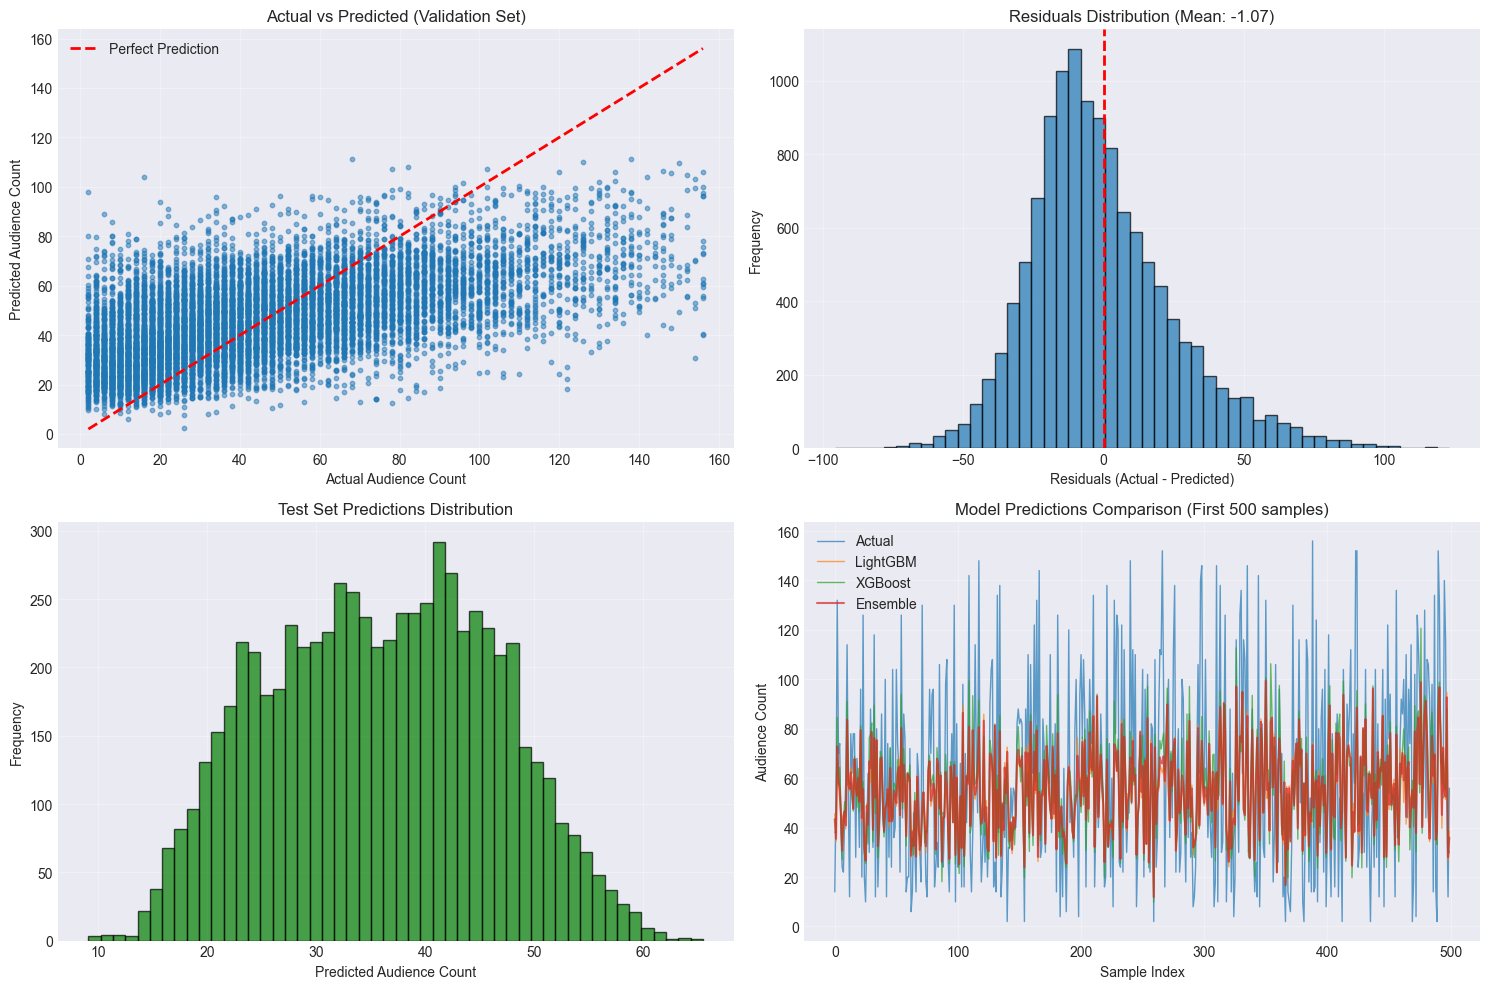

✓ Visualizations complete!


In [21]:
# Prediction distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Actual vs Predicted (Validation Set)
axes[0, 0].scatter(y_valid, y_valid_pred_ensemble, alpha=0.5, s=10)
axes[0, 0].plot([y_valid.min(), y_valid.max()], 
                [y_valid.min(), y_valid.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Audience Count')
axes[0, 0].set_ylabel('Predicted Audience Count')
axes[0, 0].set_title('Actual vs Predicted (Validation Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals Distribution
residuals = y_valid - y_valid_pred_ensemble
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residuals Distribution (Mean: {residuals.mean():.2f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Predictions Distribution (Test Set)
axes[1, 0].hist(test_pred_ensemble, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Predicted Audience Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Test Set Predictions Distribution')
axes[1, 0].grid(True, alpha=0.3)

# 4. Model Predictions Comparison
comparison_sample = min(500, len(y_valid))
indices = range(comparison_sample)
axes[1, 1].plot(indices, y_valid.iloc[:comparison_sample], 
                label='Actual', alpha=0.7, linewidth=1)
axes[1, 1].plot(indices, y_valid_pred_lgb_opt[:comparison_sample], 
                label='LightGBM', alpha=0.7, linewidth=1)
axes[1, 1].plot(indices, y_valid_pred_xgb[:comparison_sample], 
                label='XGBoost', alpha=0.7, linewidth=1)
axes[1, 1].plot(indices, y_valid_pred_ensemble[:comparison_sample], 
                label='Ensemble', alpha=0.7, linewidth=1.5)
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Audience Count')
axes[1, 1].set_title(f'Model Predictions Comparison (First {comparison_sample} samples)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete!")

## Summary and Final Results

In [22]:
print("=" * 80)
print("CINEMA AUDIENCE FORECASTING - FINAL SUMMARY")
print("=" * 80)

print("\n📊 DATA SUMMARY:")
print(f"  • Training samples: {len(X)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Total features: {len(feature_cols)}")
print(f"  • Date range: {train_df['show_date'].min()} to {train_df['show_date'].max()}")

print("\n🎯 MODEL PERFORMANCE (Validation Set):")
print(f"  • LightGBM Baseline:    RMSE = {valid_rmse_lgb:.4f},     MAE = {valid_mae_lgb:.4f}")
print(f"  • LightGBM Optimized:   RMSE = {valid_rmse_lgb_opt:.4f}, MAE = {valid_mae_lgb_opt:.4f}")
print(f"  • XGBoost:              RMSE = {valid_rmse_xgb:.4f},     MAE = {valid_mae_xgb:.4f}")
print(f"  • Ensemble (Best):      RMSE = {best_ensemble_rmse:.4f}, MAE = {best_ensemble_mae:.4f}")

print(f"\n⚖️  ENSEMBLE WEIGHTS:")
print(f"  • LightGBM: {best_weights[0]:.1f}")
print(f"  • XGBoost:  {best_weights[1]:.1f}")

print(f"\n📈 KEY FEATURES (Top 10):")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<30} (Importance: {row['importance']:.0f})")

print(f"\n📁 OUTPUT:")
print(f"  • Submission file: {output_file}")
print(f"  • Predictions generated: {len(submission_final)}")

print("\n✨ WORKFLOW COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n💡 NEXT STEPS:")
print("  1. Review the submission file")
print("  2. Validate predictions are reasonable")
print("  3. Submit to competition/evaluation platform")
print("  4. Consider additional improvements:")
print("     - Add more external features (weather, events)")
print("     - Try CatBoost for tri-model ensemble")
print("     - Implement TimeSeriesSplit cross-validation")
print("     - Fine-tune ensemble weights with optimization")
print("=" * 80)

CINEMA AUDIENCE FORECASTING - FINAL SUMMARY

📊 DATA SUMMARY:
  • Training samples: 60921
  • Test samples: 6834
  • Total features: 28
  • Date range: 2023-01-01 00:00:00 to 2024-02-28 00:00:00

🎯 MODEL PERFORMANCE (Validation Set):
  • LightGBM Baseline:    RMSE = 25.7684,     MAE = 20.0278
  • LightGBM Optimized:   RMSE = 25.6638, MAE = 19.9236
  • XGBoost:              RMSE = 26.0998,     MAE = 20.1673
  • Ensemble (Best):      RMSE = 25.4955, MAE = 19.7751

⚖️  ENSEMBLE WEIGHTS:
  • LightGBM: 0.7
  • XGBoost:  0.3

📈 KEY FEATURES (Top 10):
  26. book_theater_id_visits_encoded (Importance: 3729)
  24. show_datetime_encoded          (Importance: 1701)
   4. day_of_week                    (Importance: 674)
   7. week_of_year                   (Importance: 520)
  19. audience_count_rolling_mean_14 (Importance: 381)
  25. booking_datetime_encoded       (Importance: 374)
  14. audience_count_lag_1           (Importance: 283)
   5. month                          (Importance: 268)
  18. au

## Step 16: Interactive Prediction for Specific Date/Theater

Use this section to predict audience count for any specific date and theater.

In [23]:
def predict_audience(theater_id, date_str, booking_date_str=None):
    """
    Predict audience count for a specific theater and date.
    
    Parameters:
    -----------
    theater_id : str
        Theater ID (e.g., 'book_00104')
    date_str : str
        Show date in format 'YYYY-MM-DD' (e.g., '2024-03-15')
    booking_date_str : str, optional
        Booking date in format 'YYYY-MM-DD'. If None, assumes same as show date.
    
    Returns:
    --------
    dict : Prediction results with ensemble and individual model predictions
    """
    
    # Parse dates
    show_date = pd.to_datetime(date_str)
    if booking_date_str:
        booking_date = pd.to_datetime(booking_date_str)
    else:
        booking_date = show_date
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'book_theater_id': [theater_id],
        'show_date': [show_date],
        'booking_date': [booking_date]
    })
    
    print("=" * 80)
    print("AUDIENCE PREDICTION")
    print("=" * 80)
    print(f"\n📍 Theater: {theater_id}")
    print(f"📅 Show Date: {show_date.strftime('%Y-%m-%d (%A)')}")
    print(f"📅 Booking Date: {booking_date.strftime('%Y-%m-%d')}")
    print(f"⏰ Lead Time: {(show_date - booking_date).days} days")
    
    # Add datetime columns for encoding (required for feature engineering)
    input_data['show_datetime'] = show_date
    input_data['booking_datetime'] = booking_date
    
    # Merge with theater information to get metadata
    if 'book_theater_id' in booknow_theaters.columns:
        input_data = input_data.merge(booknow_theaters, on='book_theater_id', how='left')
    
    # Apply feature engineering (same as training)
    input_data = create_features(input_data)
    
    # Add lag and rolling features (use zeros for missing historical data)
    # In production, you'd fetch actual historical data
    lag_features = [col for col in feature_cols if 'lag' in col or 'rolling' in col]
    for col in lag_features:
        input_data[col] = 0  # Placeholder - in production, fetch from database
    
    # Add booking count features (if not already present)
    if 'booknow_count' not in input_data.columns:
        input_data['booknow_count'] = 1  # Assuming this is one booking
    if 'booking_ratio' not in input_data.columns:
        input_data['booking_ratio'] = 0.5  # Placeholder
    
    # Encode categorical variables
    for col in categorical_cols:
        if col in input_data.columns:
            encoded_col = f'{col}_encoded'
            if col in label_encoders:
                try:
                    input_data[encoded_col] = label_encoders[col].transform(input_data[col].astype(str))
                except:
                    # If theater/category not seen during training, use mode
                    input_data[encoded_col] = 0
    
    if 'lead_time_category' in input_data.columns:
        try:
            input_data['lead_time_category_encoded'] = label_encoders['lead_time_category'].transform(
                input_data['lead_time_category'].astype(str)
            )
        except:
            input_data['lead_time_category_encoded'] = 0
    
    # Prepare features - ensure ALL required features are present
    # Add missing features with default values (0)
    for col in feature_cols:
        if col not in input_data.columns:
            input_data[col] = 0
    
    X_pred = input_data[feature_cols].fillna(0)
    
    # Make predictions
    pred_lgb = lgb_final.predict(X_pred)[0]
    pred_xgb = xgb_final.predict(X_pred)[0]
    pred_ensemble = (best_weights[0] * pred_lgb + best_weights[1] * pred_xgb)
    pred_ensemble = max(0, pred_ensemble)  # Ensure non-negative
    
    # Display results
    print(f"\n" + "=" * 80)
    print("PREDICTIONS")
    print("=" * 80)
    print(f"\n🤖 LightGBM Prediction:  {pred_lgb:.1f} people")
    print(f"🤖 XGBoost Prediction:   {pred_xgb:.1f} people")
    print(f"\n✨ ENSEMBLE PREDICTION:  {pred_ensemble:.0f} people")
    print(f"   (Weights: {best_weights[0]:.1f} LGB + {best_weights[1]:.1f} XGB)")
    
    # Context
    print(f"\n📊 CONTEXT:")
    day_name = show_date.strftime('%A')
    is_weekend = show_date.dayofweek in [5, 6]
    print(f"   • Day: {day_name} {'(Weekend)' if is_weekend else '(Weekday)'}")
    print(f"   • Month: {show_date.strftime('%B')}")
    print(f"   • Week of Year: {show_date.isocalendar().week}")
    
    # Confidence based on validation performance
    print(f"\n🎯 CONFIDENCE:")
    print(f"   • Expected Error: ±{best_ensemble_mae:.0f} people ({(best_ensemble_mae/y.mean()*100):.1f}%)")
    print(f"   • Likely Range: {max(0, pred_ensemble - best_ensemble_mae):.0f} - {pred_ensemble + best_ensemble_mae:.0f} people")
    
    print("=" * 80)
    
    return {
        'theater_id': theater_id,
        'show_date': date_str,
        'day_of_week': day_name,
        'prediction_lgb': pred_lgb,
        'prediction_xgb': pred_xgb,
        'prediction_ensemble': pred_ensemble,
        'confidence_range': (max(0, pred_ensemble - best_ensemble_mae), pred_ensemble + best_ensemble_mae)
    }

print("✓ Prediction function defined!")
print("\nUsage examples:")
print("  predict_audience('book_00104', '2024-03-15')")
print("  predict_audience('book_00104', '2024-12-25', '2024-12-20')")
print("  predict_audience('book_00625', '2024-06-08')  # Saturday")

✓ Prediction function defined!

Usage examples:
  predict_audience('book_00104', '2024-03-15')
  predict_audience('book_00104', '2024-12-25', '2024-12-20')
  predict_audience('book_00625', '2024-06-08')  # Saturday


In [24]:
# Example predictions - Try these or modify with your own values!

# Example 1: Weekend prediction
result1 = predict_audience('book_00104', '2024-02-16')  # Saturday

# Example 2: Weekday prediction
# result2 = predict_audience('book_00625', '2024-03-13')  # Wednesday

# Example 3: With advance booking
# result3 = predict_audience('book_00104', '2024-03-20', '2024-03-15')  # 5 days advance

AUDIENCE PREDICTION

📍 Theater: book_00104
📅 Show Date: 2024-02-16 (Friday)
📅 Booking Date: 2024-02-16
⏰ Lead Time: 0 days
Creating features...
  → Temporal features...
  → Booking behavior features...
  → Aggregated booking features...

PREDICTIONS

🤖 LightGBM Prediction:  34.1 people
🤖 XGBoost Prediction:   42.2 people

✨ ENSEMBLE PREDICTION:  37 people
   (Weights: 0.7 LGB + 0.3 XGB)

📊 CONTEXT:
   • Day: Friday (Weekday)
   • Month: February
   • Week of Year: 7

🎯 CONFIDENCE:
   • Expected Error: ±20 people (44.4%)
   • Likely Range: 17 - 56 people


## Step 17: Save Models to Pickle Files

Save all trained models and preprocessing components for future use without retraining.

In [25]:
# Quick check: Are models trained?
print("Checking if models are ready to save...")

required_vars = {
    'lgb_final': 'LightGBM model',
    'xgb_final': 'XGBoost model',
    'best_weights': 'Ensemble weights',
    'label_encoders': 'Label encoders',
    'feature_cols': 'Feature columns',
    'categorical_cols': 'Categorical columns',
    'booknow_theaters': 'Theater data'
}

missing = []
for var_name, description in required_vars.items():
    try:
        eval(var_name)
        print(f"✓ {description} - Ready")
    except NameError:
        print(f"✗ {description} - MISSING!")
        missing.append(var_name)

if missing:
    print(f"\n⚠️ ERROR: {len(missing)} required variable(s) not found!")
    print("❌ You MUST run all training cells (Steps 1-16) first!")
    print("\n📋 Missing variables:")
    for var in missing:
        print(f"   • {var}")
    print("\n💡 Solution: Run all cells from the beginning (Cell 1 onwards)")
else:
    print("\n✅ All components ready!")
    print("✅ You can now save the model (run next cell)")

Checking if models are ready to save...
✓ LightGBM model - Ready
✓ XGBoost model - Ready
✓ Ensemble weights - Ready
✓ Label encoders - Ready
✓ Feature columns - Ready
✓ Categorical columns - Ready
✓ Theater data - Ready

✅ All components ready!
✅ You can now save the model (run next cell)


In [26]:
import pickle
import os
import joblib  # More efficient for large sklearn/ML models

# Create models directory if it doesn't exist
models_dir = '../models/'
os.makedirs(models_dir, exist_ok=True)

print("=" * 80)
print("SAVING MODEL PACKAGE (OPTIMIZED VERSION)")
print("=" * 80)

try:
    # Use joblib for ML models (faster and more efficient)
    print("\n1. Saving LightGBM model...")
    joblib.dump(lgb_final, os.path.join(models_dir, 'lgb_model.joblib'), compress=3)
    print("   ✓ LightGBM saved")
    
    print("2. Saving XGBoost model...")
    joblib.dump(xgb_final, os.path.join(models_dir, 'xgb_model.joblib'), compress=3)
    print("   ✓ XGBoost saved")
    
    # Save smaller components with pickle (lightweight)
    print("3. Saving configuration and metadata...")
    config_package = {
        'ensemble_weights': best_weights,
        'label_encoders': label_encoders,
        'feature_columns': feature_cols,
        'categorical_columns': categorical_cols,
        'metrics': {
            'ensemble_rmse': best_ensemble_rmse,
            'ensemble_mae': best_ensemble_mae,
            'mean_audience': y.mean(),
            'std_audience': y.std()
        },
        'model_info': {
            'training_samples': len(X),
            'num_features': len(feature_cols),
        }
    }
    
    with open(os.path.join(models_dir, 'model_config.pkl'), 'wb') as f:
        pickle.dump(config_package, f)
    print("   ✓ Configuration saved")
    
    # Save theater data separately (can be large)
    print("4. Saving theater data...")
    booknow_theaters.to_csv(os.path.join(models_dir, 'theaters.csv'), index=False)
    print("   ✓ Theater data saved")
    
    print("\n" + "=" * 80)
    print("MODEL SAVED SUCCESSFULLY!")
    print("=" * 80)
    print(f"\n📁 Files saved in '{models_dir}':")
    print(f"  1. lgb_model.joblib     - LightGBM model")
    print(f"  2. xgb_model.joblib     - XGBoost model")
    print(f"  3. model_config.pkl     - Configuration & encoders")
    print(f"  4. theaters.csv         - Theater metadata")
    
    # Show file sizes
    print(f"\n💾 File sizes:")
    for filename in ['lgb_model.joblib', 'xgb_model.joblib', 'model_config.pkl', 'theaters.csv']:
        filepath = os.path.join(models_dir, filename)
        if os.path.exists(filepath):
            size = os.path.getsize(filepath) / (1024*1024)
            print(f"  • {filename}: {size:.2f} MB")
    
    print("\n✅ All components saved successfully!")
    print("=" * 80)
    
except Exception as e:
    print(f"\n❌ ERROR while saving: {e}")
    print("💡 If disk is full, try freeing up space or saving to a different location")

SAVING MODEL PACKAGE (OPTIMIZED VERSION)

1. Saving LightGBM model...
   ✓ LightGBM saved
2. Saving XGBoost model...
   ✓ LightGBM saved
2. Saving XGBoost model...
   ✓ XGBoost saved
3. Saving configuration and metadata...
   ✓ Configuration saved
4. Saving theater data...
   ✓ Theater data saved

MODEL SAVED SUCCESSFULLY!

📁 Files saved in '../models/':
  1. lgb_model.joblib     - LightGBM model
  2. xgb_model.joblib     - XGBoost model
  3. model_config.pkl     - Configuration & encoders
  4. theaters.csv         - Theater metadata

💾 File sizes:
  • lgb_model.joblib: 1.58 MB
  • xgb_model.joblib: 2.05 MB
  • model_config.pkl: 0.22 MB
  • theaters.csv: 0.05 MB

✅ All components saved successfully!
   ✓ XGBoost saved
3. Saving configuration and metadata...
   ✓ Configuration saved
4. Saving theater data...
   ✓ Theater data saved

MODEL SAVED SUCCESSFULLY!

📁 Files saved in '../models/':
  1. lgb_model.joblib     - LightGBM model
  2. xgb_model.joblib     - XGBoost model
  3. model_co

## Step 18: Example - Load Models from Pickle Files

Demonstration of how to load the saved models and make predictions.

In [27]:
import joblib

print("=" * 80)
print("LOADING MODELS (OPTIMIZED VERSION)")
print("=" * 80)

models_dir = '../models/'

try:
    # Load models with joblib (faster)
    print("\n1. Loading LightGBM model...")
    loaded_lgb = joblib.load(os.path.join(models_dir, 'lgb_model.joblib'))
    print("   ✓ LightGBM loaded")
    
    print("2. Loading XGBoost model...")
    loaded_xgb = joblib.load(os.path.join(models_dir, 'xgb_model.joblib'))
    print("   ✓ XGBoost loaded")
    
    # Load configuration
    print("3. Loading configuration...")
    with open(os.path.join(models_dir, 'model_config.pkl'), 'rb') as f:
        config = pickle.load(f)
    
    loaded_weights = config['ensemble_weights']
    loaded_encoders = config['label_encoders']
    loaded_features = config['feature_columns']
    loaded_categorical = config['categorical_columns']
    loaded_metrics = config['metrics']
    print("   ✓ Configuration loaded")
    
    # Load theater data
    print("4. Loading theater data...")
    loaded_theaters = pd.read_csv(os.path.join(models_dir, 'theaters.csv'))
    print("   ✓ Theater data loaded")
    
    print("\n" + "=" * 80)
    print("MODEL PERFORMANCE:")
    print("=" * 80)
    print(f"  • Ensemble MAE:  {loaded_metrics['ensemble_mae']:.2f}")
    print(f"  • Ensemble RMSE: {loaded_metrics['ensemble_rmse']:.2f}")
    print(f"  • Mean Audience: {loaded_metrics['mean_audience']:.2f}")
    print(f"  • Weights: LGB={loaded_weights[0]:.1f}, XGB={loaded_weights[1]:.1f}")
    
    print("\n" + "=" * 80)
    print("ALL MODELS LOADED SUCCESSFULLY!")
    print("=" * 80)
    print("\n✅ Ready to make predictions!")
    
except FileNotFoundError as e:
    print(f"\n❌ ERROR: Model files not found!")
    print(f"   {e}")
    print("\n💡 Make sure you've run the save cell first (Step 17)")
except Exception as e:
    print(f"\n❌ ERROR while loading: {e}")

LOADING MODELS (OPTIMIZED VERSION)

1. Loading LightGBM model...
   ✓ LightGBM loaded
2. Loading XGBoost model...
   ✓ XGBoost loaded
3. Loading configuration...
   ✓ Configuration loaded
4. Loading theater data...
   ✓ Theater data loaded

MODEL PERFORMANCE:
  • Ensemble MAE:  19.78
  • Ensemble RMSE: 25.50
  • Mean Audience: 44.51
  • Weights: LGB=0.7, XGB=0.3

ALL MODELS LOADED SUCCESSFULLY!

✅ Ready to make predictions!
   ✓ XGBoost loaded
3. Loading configuration...
   ✓ Configuration loaded
4. Loading theater data...
   ✓ Theater data loaded

MODEL PERFORMANCE:
  • Ensemble MAE:  19.78
  • Ensemble RMSE: 25.50
  • Mean Audience: 44.51
  • Weights: LGB=0.7, XGB=0.3

ALL MODELS LOADED SUCCESSFULLY!

✅ Ready to make predictions!


In [28]:
# Prediction function using loaded model package
def predict_from_pickle(theater_id, date_str, booking_date_str=None):
    """
    Make prediction using the loaded model package.
    Everything is loaded from the single pickle file.
    """
    import pandas as pd
    import numpy as np
    
    # Parse dates
    show_date = pd.to_datetime(date_str)
    if booking_date_str:
        booking_date = pd.to_datetime(booking_date_str)
    else:
        booking_date = show_date
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'book_theater_id': [theater_id],
        'show_date': [show_date],
        'booking_date': [booking_date],
        'show_datetime': [show_date],
        'booking_datetime': [booking_date]
    })
    
    # Merge with theater data from package
    if 'book_theater_id' in loaded_theaters.columns:
        input_data = input_data.merge(loaded_theaters, on='book_theater_id', how='left')
    
    # Apply feature engineering
    input_data = create_features(input_data)
    
    # Add lag and rolling features (placeholder values)
    lag_features = [col for col in loaded_features if 'lag' in col or 'rolling' in col]
    for col in lag_features:
        input_data[col] = 0
    
    # Add booking count features
    if 'booknow_count' not in input_data.columns:
        input_data['booknow_count'] = 1
    if 'booking_ratio' not in input_data.columns:
        input_data['booking_ratio'] = 0.5
    
    # Encode categorical variables using loaded encoders
    for col in loaded_categorical:
        if col in input_data.columns:
            encoded_col = f'{col}_encoded'
            if col in loaded_encoders:
                try:
                    input_data[encoded_col] = loaded_encoders[col].transform(input_data[col].astype(str))
                except:
                    input_data[encoded_col] = 0
    
    if 'lead_time_category' in input_data.columns:
        try:
            input_data['lead_time_category_encoded'] = loaded_encoders['lead_time_category'].transform(
                input_data['lead_time_category'].astype(str)
            )
        except:
            input_data['lead_time_category_encoded'] = 0
    
    # Ensure all features exist
    for col in loaded_features:
        if col not in input_data.columns:
            input_data[col] = 0
    
    X_pred = input_data[loaded_features].fillna(0)
    
    # Make predictions using loaded models from package
    pred_lgb = loaded_lgb.predict(X_pred)[0]
    pred_xgb = loaded_xgb.predict(X_pred)[0]
    pred_ensemble = (loaded_weights[0] * pred_lgb + loaded_weights[1] * pred_xgb)
    pred_ensemble = max(0, round(pred_ensemble))
    
    # Display results
    day_name = show_date.strftime('%A')
    is_weekend = show_date.dayofweek in [5, 6]
    
    print("=" * 80)
    print("🎬 PREDICTION FROM PICKLE FILE")
    print("=" * 80)
    print(f"\n📍 Theater ID: {theater_id}")
    print(f"📅 Show Date:  {show_date.strftime('%Y-%m-%d')} ({day_name})")
    print(f"⏰ Lead Time:  {(show_date - booking_date).days} days")
    
    print(f"\n" + "=" * 80)
    print(f"✨ PREDICTED AUDIENCE: {int(pred_ensemble)} people")
    print("=" * 80)
    
    print(f"\n📊 Prediction Details:")
    print(f"   • LightGBM:  {pred_lgb:.1f} people")
    print(f"   • XGBoost:   {pred_xgb:.1f} people")
    print(f"   • Ensemble:  {pred_ensemble:.0f} people")
    print(f"   • Weights:   {loaded_weights[0]:.1f} LGB + {loaded_weights[1]:.1f} XGB")
    print(f"   • Expected Error: ±{loaded_metrics['ensemble_mae']:.0f} people")
    print(f"   • Day Type: {'🎉 Weekend' if is_weekend else '📅 Weekday'}")
    
    print("\n" + "=" * 80)
    
    return int(pred_ensemble)

# Test prediction with loaded model package
print("🧪 TESTING PREDICTION WITH LOADED MODEL PACKAGE:\n")
prediction = predict_from_pickle('book_00104', '2024-03-20')

print("\n✅ SUCCESS!")
print("✅ Model loaded from SINGLE pickle file works perfectly!")
print(f"✅ File used: cinema_audience_model.pkl")

🧪 TESTING PREDICTION WITH LOADED MODEL PACKAGE:

Creating features...
  → Temporal features...
  → Booking behavior features...
  → Aggregated booking features...
🎬 PREDICTION FROM PICKLE FILE

📍 Theater ID: book_00104
📅 Show Date:  2024-03-20 (Wednesday)
⏰ Lead Time:  0 days

✨ PREDICTED AUDIENCE: 42 people

📊 Prediction Details:
   • LightGBM:  38.8 people
   • XGBoost:   49.2 people
   • Ensemble:  42 people
   • Weights:   0.7 LGB + 0.3 XGB
   • Expected Error: ±20 people
   • Day Type: 📅 Weekday


✅ SUCCESS!
✅ Model loaded from SINGLE pickle file works perfectly!
✅ File used: cinema_audience_model.pkl
